In [15]:
#getting and working with data
import pickle

import pandas as pd
import numpy as np

import re
import string

import nltk
from nltk.tokenize import word_tokenize
from nltk.tokenize import RegexpTokenizer
from nltk.corpus import stopwords
from nltk.stem.snowball import SnowballStemmer
from nltk.tag import pos_tag


from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer
from sklearn.decomposition import NMF
from sklearn.manifold import TSNE
from sklearn.datasets import load_digits

import spacy
import en_core_web_sm
from spacy.symbols import amod

from collections import Counter

# K means
from sklearn.preprocessing import scale
from sklearn.cluster import KMeans
from sklearn.datasets import make_blobs
from sklearn.utils import shuffle

#visualizing results
%matplotlib inline
import matplotlib.pyplot as plt
import seaborn as sns
import scattertext as st
from wordcloud import WordCloud, STOPWORDS
%config InlineBackend.figure_formats = ['svg']
%matplotlib inline
from pprint import pprint

In [6]:
# Review data
data = pd.read_pickle(r'/Users/jbpatty/project-4/amazon_data_cleaned.to_pickle')

In [7]:
data.sample(5)

,overall,verified,review_time,reviewer_ID,asin,reviewer_name,review_text,summary
365971,5.0,True,2015-07-20,A3IX8U1ARTDNGF,B000WLHOY2,ELRA12,Perfect as a substitute with other flours for ...,Perfect as a substitute with other flours for ...
502590,5.0,True,2015-06-12,A2ZVSVHZJKGUOV,B001QTKZKY,Lauren,My favorite English candy on the planet,Five Stars
553061,5.0,True,2010-04-02,A7IE2RB3P8V3X,B002L46PS4,C. Baker,Before I got my keurig coffee maker I always b...,good coffee
430214,5.0,True,2017-08-09,A3MLKIM37CL7QD,B0017O19Q2,Amazon Customer,Great Products,Five Stars
91209,1.0,True,2017-03-05,ABUM3MZGQFKOD,B000HGEC56,Loren G.,my 28 month ikd won't touch these cause his ja...,my 28 month ikd won't touch these cause his ja...


In [8]:
len(data)

500845

In [9]:
# While most reviewers leave a 5 star review, there are also a samll portion leaving 1 and 2 star reviews
data.overall.value_counts(normalize=True)

5.0    0.766423
4.0    0.103188
3.0    0.050465
1.0    0.048863
2.0    0.031062
Name: overall, dtype: float64

In [10]:
# Remove 3 star reviews
reviews = data[data.overall!=3]

# Set 4/5 star reviews to positive, the rest to negative
reviews['sentiment'] = np.where(reviews['overall'] >= 4, 'positive', 'negative')

# Include only the sentiment and reviews columns
reviews_compiled = reviews[['sentiment', 'review_text', 'asin']]

In [11]:
reviews_compiled = reviews_compiled.drop_duplicates()

In [12]:
reviews_compiled.to_pickle('/Users/jbpatty/project-4/reviews_compiled.pkl')

In [4]:
# Reviews df
with open('/Users/jbpatty/project-4/reviews_compiled.pkl','rb') as read_file:
    reviews_compiled = pickle.load(read_file)

In [14]:
reviews_compiled.shape

(428177, 3)

In [15]:
# Note that the dataset has mostly positive reviews
reviews_compiled.sentiment.value_counts(normalize=True)

positive    0.914535
negative    0.085465
Name: sentiment, dtype: float64

In [16]:
reviews_compiled.sample(5)

,sentiment,review_text,asin
705064,positive,This will probably last the rest of my life as...,B004W8LT10
506822,positive,love it,B001SB5Y8S
803988,positive,My son loved his mario cake best birthday ever,B005K1Z2HA
499418,positive,Love the colors,B001O8KQP6
658971,positive,Perfect-exactly what I expected. Came quickly...,B003ZJNJLA


### Pre-Process the text

In [5]:
# Reviews - text preprocessing steps - remove numbers, captial letters, punctuation, and repetitive letters
def preprocess(docs):
    """
    Preprocess a corpus (Series) of documents before using a vectorizer
    - remove numbers and punctuation
    - convert all text to lower case
    """
    # Remove numbers and punctuation
    alphanumeric = lambda x: re.sub('\w*\d\w*', ' ', x)
    
    # Convert all text to lowercase
    punc_lower = lambda x: re.sub('[%s]' % re.escape(string.punctuation), ' ', x.lower())
    
    # Remove repetitve letters 
    repeat_pattern = lambda x: re.sub(r'(\w)\1*', r'\1', x)
    
    return docs.map(alphanumeric).map(punc_lower).map(repeat_pattern)

<>:9: DeprecationWarning: invalid escape sequence \w
<>:9: DeprecationWarning: invalid escape sequence \w
<ipython-input-5-694c47508392>:9: DeprecationWarning: invalid escape sequence \w
  alphanumeric = lambda x: re.sub('\w*\d\w*', ' ', x)


In [6]:
reviews_compiled['review_text'] = preprocess(reviews_compiled['review_text'])

In [19]:
ex_label = reviews_compiled['review_text']

In [20]:
# Diplay topics from CountVectorizer and Tfidf

def display_topics(model, feature_names, no_top_words, topic_names=None):
    """
    Display topics and top associated words given a topic model
    """
    for ix, topic in enumerate(model.components_):
        if not topic_names or not topic_names[ix]:
            print("\nTopic ", ix)
        else:
            print("\nTopic: '",topic_names[ix],"'")
        print(", ".join([feature_names[i]
                        for i in topic.argsort()[:-no_top_words - 1:-1]]))

#### CountVectorizer

In [21]:
vectorizer = CountVectorizer(stop_words = 'english', min_df=0.0001,max_df=.92)
doc_word = vectorizer.fit_transform(reviews_compiled['review_text'])
dtm_cv = pd.DataFrame(doc_word.toarray(), index=ex_label, columns=vectorizer.get_feature_names())

In [22]:
nmf_model = NMF(5)
doc_topic = nmf_model.fit_transform(doc_word)

In [23]:
topic_word = pd.DataFrame(nmf_model.components_.round(3),
             index = ["component_1","component_2", "component_3","component_4", "component_5"],
             columns = vectorizer.get_feature_names())
topic_word

,ability,able,abroad,absolute,absolutely,absorb,absorbs,acai,acent,acept,...,yumy,yup,zero,zest,zesty,zing,zip,ziploc,ziplock,zone
component_1,0.001,0.037,0.002,0.000,0.000,0.001,0.000,0.003,0.000,0.000,...,0.079,0.001,0.002,0.000,0.001,0.000,0.005,0.001,0.001,0.002
component_2,0.002,0.071,0.000,0.002,0.020,0.000,0.002,0.000,0.002,0.001,...,0.056,0.001,0.006,0.001,0.000,0.001,0.005,0.002,0.003,0.000
component_3,0.003,0.086,0.002,0.011,0.228,0.000,0.001,0.001,0.001,0.000,...,0.130,0.000,0.004,0.001,0.001,0.004,0.004,0.001,0.000,0.001
component_4,0.006,0.236,0.002,0.042,0.231,0.006,0.004,0.004,0.002,0.004,...,0.261,0.001,0.035,0.007,0.005,0.012,0.019,0.004,0.008,0.004
component_5,0.004,0.089,0.000,0.017,0.054,0.000,0.000,0.000,0.000,0.001,...,0.007,0.000,0.009,0.000,0.000,0.000,0.000,0.000,0.000,0.000


In [24]:
display_topics(nmf_model, vectorizer.get_feature_names(), 25)


Topic  0
god, product, price, realy, quality, stuf, buy, taste, tastes, flavor, fresh, prety, time, value, wel, arived, wil, litle, deal, nice, order, fast, chocolate, stil, candy

Topic  1
great, product, price, taste, flavor, use, tastes, quality, buy, wil, value, fast, tasting, time, snack, works, deal, wel, recomend, shiping, arived, fresh, stuf, make, service

Topic  2
love, stuf, tea, wil, use, flavor, al, kids, product, buy, amazon, time, order, delicious, absolutely, oil, chocolate, price, coconut, favorite, perfect, stores, eat, make, candy

Topic  3
like, taste, just, tea, flavor, wil, al, use, realy, best, buy, time, don, make, litle, product, delicious, ve, beter, used, tried, sugar, tastes, bought, chocolate

Topic  4
cofe, cup, best, flavor, favorite, strong, cups, morning, drink, keurig, use, smoth, tried, roast, bold, decaf, ve, ben, price, biter, amazon, maker, blend, tasting, flavored


In [26]:
H = pd.DataFrame(doc_topic.round(5),
             index = ex_label,
             columns = ["component_1","component_2", "component_3","component_4", "component_5"])
H

,component_1,component_2,component_3,component_4,component_5
review_text,,,,,
very pleased with my purchase loks exactly like the picture and wil lok great on my cake it definitely wil sparkle,0.00000,0.05636,0.00000,0.06360,0.00000
very nicely crafted but to smal am going to have to ad some flowers or something to compensate for the size,0.00057,0.00087,0.00084,0.00728,0.00016
it was just what i want to put at the top of my weding cake i love it it s true to the picture,0.00000,0.00000,0.06578,0.01742,0.00000
omg the s was inexpensive and exactly what we wanted i searched everywhere and this one was the best one,0.00000,0.00000,0.00000,0.00995,0.00621
this was exactly what we were loking for to make our cake sparkle along with the strands of diamonds we already have on the cake,0.00031,0.00116,0.00023,0.01082,0.00034
...,...,...,...,...,...
i had one dead plant tried to reach hirt gardens and unable to reach anyone other plants were healthy,0.00018,0.00029,0.00013,0.00642,0.00151
al plants healthy al plants grew while stil planted in their original pots growing famously in terarium,0.00044,0.00019,0.00212,0.02845,0.00000
these plants arived in excelent condition and are thriving in my terarium,0.00145,0.00207,0.00000,0.00363,0.00073


#### TF-IDF

In [27]:
vectorizer_tf = CountVectorizer(stop_words = 'english')
doc_word_tf = vectorizer_tf.fit_transform(reviews_compiled['review_text'])
dtm_tf = pd.DataFrame(doc_word_tf.toarray(), index=ex_label, columns=vectorizer_tf.get_feature_names())

In [28]:
nmf_model_tf = NMF(7)
doc_topic_tf = nmf_model_tf.fit_transform(doc_word_tf)

In [29]:
topic_word_tf = pd.DataFrame(nmf_model_tf.components_.round(3),
             index = ["component_1","component_2", "component_3","component_4", "component_5", "component_6","component_7"],
             columns = vectorizer_tf.get_feature_names())
topic_word_tf

,ab,aback,abalone,abandon,abandoned,abandoning,abas,abated,abating,abc,...,zurich,zuto,zweigle,zweigles,zwiebach,zwieback,zylitol,zyloswet,zym,zyrtec
component_1,0.000,0.000,0.000,0.0,0.000,0.000,0.0,0.0,0.0,0.000,...,0.0,0.0,0.0,0.0,0.0,0.0,0.000,0.0,0.0,0.0
component_2,0.000,0.000,0.000,0.0,0.000,0.000,0.0,0.0,0.0,0.000,...,0.0,0.0,0.0,0.0,0.0,0.0,0.000,0.0,0.0,0.0
component_3,0.000,0.000,0.000,0.0,0.000,0.000,0.0,0.0,0.0,0.001,...,0.0,0.0,0.0,0.0,0.0,0.0,0.000,0.0,0.0,0.0
component_4,0.000,0.000,0.001,0.0,0.001,0.000,0.0,0.0,0.0,0.001,...,0.0,0.0,0.0,0.0,0.0,0.0,0.000,0.0,0.0,0.0
component_5,0.002,0.000,0.000,0.0,0.000,0.000,0.0,0.0,0.0,0.000,...,0.0,0.0,0.0,0.0,0.0,0.0,0.000,0.0,0.0,0.0
component_6,0.000,0.002,0.000,0.0,0.001,0.001,0.0,0.0,0.0,0.000,...,0.0,0.0,0.0,0.0,0.0,0.0,0.000,0.0,0.0,0.0
component_7,0.000,0.000,0.000,0.0,0.000,0.000,0.0,0.0,0.0,0.000,...,0.0,0.0,0.0,0.0,0.0,0.0,0.001,0.0,0.0,0.0


In [30]:
display_topics(nmf_model_tf, vectorizer_tf.get_feature_names(), 20)


Topic  0
god, price, realy, quality, stuf, flavor, tastes, buy, taste, prety, fresh, value, litle, deal, wel, nice, time, chocolate, arived, candy

Topic  1
great, price, taste, flavor, tastes, tasting, value, snack, deal, stuf, quality, works, fast, buy, use, makes, make, easy, fresh, litle

Topic  2
love, stuf, flavor, al, wil, use, kids, buy, just, amazon, time, order, delicious, chocolate, oil, absolutely, coconut, eat, candy, make

Topic  3
like, taste, just, al, flavor, wil, realy, use, don, buy, litle, make, time, tastes, beter, chocolate, best, sugar, delicious, tried

Topic  4
cofe, cup, best, flavor, favorite, use, strong, cups, morning, drink, keurig, tried, ve, smoth, ben, roast, amazon, bold, wil, decaf

Topic  5
tea, flavor, best, gren, drink, favorite, cup, bags, iced, hot, wil, teas, make, ve, delicious, black, nice, ben, use, day

Topic  6
product, wil, use, excelent, time, buy, order, price, recomend, used, ben, al, quality, amazon, arived, wel, purchase, best, hapy,

In [31]:
H_tf = pd.DataFrame(doc_topic_tf.round(5),
             index = ex_label,
             columns = ["component_1","component_2", "component_3","component_4", "component_5", "component_6","component_7"])
H_tf

,component_1,component_2,component_3,component_4,component_5,component_6,component_7
review_text,,,,,,,
very pleased with my purchase loks exactly like the picture and wil lok great on my cake it definitely wil sparkle,0.00000,0.05786,0.00000,0.06246,0.00000,0.00000,0.01657
very nicely crafted but to smal am going to have to ad some flowers or something to compensate for the size,0.00067,0.00105,0.00113,0.00643,0.00038,0.00113,0.00080
it was just what i want to put at the top of my weding cake i love it it s true to the picture,0.00000,0.00000,0.06655,0.01999,0.00000,0.00000,0.00000
omg the s was inexpensive and exactly what we wanted i searched everywhere and this one was the best one,0.00000,0.00000,0.00015,0.00514,0.00718,0.00610,0.00246
this was exactly what we were loking for to make our cake sparkle along with the strands of diamonds we already have on the cake,0.00034,0.00101,0.00058,0.00885,0.00078,0.00177,0.00280
...,...,...,...,...,...,...,...
i had one dead plant tried to reach hirt gardens and unable to reach anyone other plants were healthy,0.00025,0.00048,0.00035,0.00541,0.00176,0.00107,0.00089
al plants healthy al plants grew while stil planted in their original pots growing famously in terarium,0.00081,0.00054,0.00359,0.02619,0.00023,0.00000,0.00377
these plants arived in excelent condition and are thriving in my terarium,0.00079,0.00076,0.00000,0.00026,0.00077,0.00097,0.00822


### Spacy

In [40]:
nlp = en_core_web_sm.load()

In [41]:
reviews_spacy = reviews_compiled['review_text']

In [42]:
doc = nlp(reviews_compiled['review_text'][0])

In [43]:
for token in doc:
    print(token.text, token.pos_, token.lemma_, token.is_stop)

very ADV very True
pleased ADJ pleased False
with ADP with True
my DET -PRON- True
purchase NOUN purchase False
  SPACE   False
loks VERB lok False
exactly ADV exactly False
like SCONJ like False
the DET the True
picture NOUN picture False
and CCONJ and True
wil VERB wil False
lok VERB lok False
great ADJ great False
on ADP on True
my DET -PRON- True
cake NOUN cake False
  SPACE   False
it PRON -PRON- True
definitely ADV definitely False
wil VERB wil False
sparkle NOUN sparkle False


In [44]:
doc.text

'very pleased with my purchase  loks exactly like the picture and wil lok great on my cake  it definitely wil sparkle '

In [45]:
type(doc.sents)

generator

In [46]:
for sent in doc.sents:
    print(sent)

very pleased with my purchase  loks exactly like the picture and wil lok great on my cake  
it definitely wil sparkle


Dependencies

In [47]:
for token in doc:
    print(token.text, token.dep_)

very advmod
pleased ROOT
with prep
my poss
purchase pobj
  
loks pobj
exactly advmod
like prep
the det
picture pobj
and cc
wil compound
lok conj
great amod
on prep
my poss
cake pobj
  
it nsubj
definitely advmod
wil ROOT
sparkle dobj


In [48]:
# visualizing these relationships
from spacy import displacy
displacy.render(doc, style='dep', options={'distance': 80})

In [49]:
reviews_compiled.to_pickle('/Users/jbpatty/project-4/reviews_compiled_dependencies.pkl')

Pipelines

In [50]:
# Reviews Spacy Dependencies df
with open('/Users/jbpatty/project-4/reviews_compiled_dependencies.pkl','rb') as read_file:
    reviews_compiled = pickle.load(read_file)

In [51]:
reviews_compiled['spacy_doc'] = list(nlp.pipe(reviews_compiled.review_text))

In [52]:
reviews_compiled

,sentiment,review_text,asin,spacy_doc
0,positive,very pleased with my purchase loks exactly li...,1888861614,"(very, pleased, with, my, purchase, , loks, e..."
1,positive,very nicely crafted but to smal am going to h...,1888861614,"(very, nicely, crafted, but, to, smal, , am, ..."
2,positive,it was just what i want to put at the top of m...,1888861614,"(it, was, just, what, i, want, to, put, at, th..."
3,positive,omg the s was inexpensive and exactly what w...,1888861614,"(omg, , the, s, was, inexpensive, and, exact..."
5,positive,this was exactly what we were loking for to ma...,1888861614,"(this, was, exactly, what, we, were, loking, f..."
...,...,...,...,...
999993,positive,i had one dead plant tried to reach hirt gard...,B007H9WMY4,"(i, had, one, dead, plant, , tried, to, reach..."
999995,positive,al plants healthy al plants grew while stil p...,B007H9WMY4,"(al, plants, healthy, , al, plants, grew, whi..."
999997,positive,these plants arived in excelent condition and ...,B007H9WMY4,"(these, plants, arived, in, excelent, conditio..."
999998,positive,al heathly,B007H9WMY4,"(al, heathly)"


Parts of Speech by Sentiment

In [53]:
# Splitting the information by sentiment

positive_reviews = reviews_compiled[reviews_compiled.sentiment == 'positive']
negative_reviews = reviews_compiled[reviews_compiled.sentiment == 'negative']

In [54]:
for token in doc:
    print(token.text, token.pos_, token.lemma_, token.is_stop)

very ADV very True
pleased ADJ pleased False
with ADP with True
my DET -PRON- True
purchase NOUN purchase False
  SPACE   False
loks VERB lok False
exactly ADV exactly False
like SCONJ like False
the DET the True
picture NOUN picture False
and CCONJ and True
wil VERB wil False
lok VERB lok False
great ADJ great False
on ADP on True
my DET -PRON- True
cake NOUN cake False
  SPACE   False
it PRON -PRON- True
definitely ADV definitely False
wil VERB wil False
sparkle NOUN sparkle False


In [55]:
# What are the most common adjectives used in positive versus negative reviews? Let's [also] check the nouns

pos_adj = [token.text.lower() for doc in positive_reviews.spacy_doc for token in doc if token.pos_=='ADJ']
neg_adj = [token.text.lower() for doc in negative_reviews.spacy_doc for token in doc if token.pos_=='ADJ']

pos_noun = [token.text.lower() for doc in positive_reviews.spacy_doc for token in doc if token.pos_=='NOUN']
neg_noun = [token.text.lower() for doc in negative_reviews.spacy_doc for token in doc if token.pos_=='NOUN']

In [56]:
Counter(pos_adj).most_common(10)

[('great', 89950),
 ('best', 28985),
 ('delicious', 13941),
 ('favorite', 13882),
 ('perfect', 13806),
 ('fresh', 13148),
 ('more', 12664),
 ('nice', 12621),
 ('other', 11626),
 ('litle', 9550)]

In [57]:
Counter(neg_adj).most_common(10)

[('bad', 1609),
 ('other', 1506),
 ('stale', 1502),
 ('old', 1389),
 ('great', 1362),
 ('much', 1362),
 ('hard', 1134),
 ('more', 1131),
 ('same', 1067),
 ('terible', 894)]

In [58]:
Counter(pos_noun).most_common(20)

[('product', 41026),
 ('taste', 28116),
 ('tea', 25749),
 ('flavor', 24949),
 ('price', 24541),
 ('cofe', 21615),
 ('time', 19235),
 ('excelent', 12643),
 ('beter', 11739),
 ('chocolate', 10532),
 ('quality', 8892),
 ('sugar', 8671),
 ('candy', 8540),
 ('water', 7976),
 ('store', 7620),
 ('way', 7481),
 ('oil', 7365),
 ('years', 7299),
 ('day', 7165),
 ('brand', 6759)]

In [59]:
Counter(neg_noun).most_common(10)

[('taste', 5508),
 ('product', 4391),
 ('flavor', 3205),
 ('cofe', 1966),
 ('time', 1695),
 ('money', 1690),
 ('tea', 1688),
 ('box', 1677),
 ('beter', 1423),
 ('chocolate', 1416)]

Dependency Parsing

In [61]:
def get_amods(noun, ser):
    amod_list = []
    for doc in ser:
        for token in doc:
            if (token.text) == noun:
                for child in token.children:
                    if child.dep == amod:
                        amod_list.append(child.text.lower())
    return sorted(amod_list)

def amods_by_sentiment(noun):
    print(f"Adjectives describing {str.upper(noun)}:\n")
    
    print("POSITIVE:")
    pprint(get_amods(noun, positive_reviews.spacy_doc))
    
    print("\nNEGATIVE:")
    pprint(get_amods(noun, negative_reviews.spacy_doc))
    
#reviews_compiled = reviews_compiled.drop_duplicates()

In [55]:
amods_by_sentiment("chocolate")

Adjectives describing CHOCOLATE:

POSITIVE:
['absolute',
 'absolute',
 'absolute',
 'absolute',
 'absolute',
 'actual',
 'actual',
 'actual',
 'actual',
 'actual',
 'actual',
 'actual',
 'aded',
 'adictive',
 'adictive',
 'adictive',
 'aerated',
 'aerated',
 'aerorated',
 'amazing',
 'amazing',
 'amazing',
 'amazing',
 'amazing',
 'amazing',
 'amazing',
 'amazing',
 'amazing',
 'amazing',
 'amazing',
 'amazing',
 'amazing',
 'amazing',
 'amazing',
 'amazing',
 'amazing',
 'amazing',
 'amazing',
 'amazing',
 'amazing',
 'amazing',
 'amazing',
 'amazing',
 'amazing',
 'amazing',
 'american',
 'american',
 'american',
 'american',
 'american',
 'american',
 'american',
 'american',
 'american',
 'american',
 'american',
 'american',
 'american',
 'american',
 'american',
 'american',
 'arctic',
 'artificial',
 'authentic',
 'authentic',
 'available',
 'available',
 'available',
 'available',
 'available',
 'available',
 'available',
 'average',
 'awesome',
 'awesome',
 'awesome',
 'awesom

 'delicious',
 'delicious',
 'delicious',
 'delicious',
 'delicious',
 'delicious',
 'delicious',
 'delicious',
 'delicious',
 'delicious',
 'delicious',
 'delicious',
 'delicious',
 'delicious',
 'delicous',
 'delish',
 'delishious',
 'dense',
 'dense',
 'dep',
 'described',
 'diabetic',
 'diet',
 'diet',
 'diping',
 'diping',
 'diping',
 'distinct',
 'distinctive',
 'domestic',
 'double',
 'double',
 'double',
 'double',
 'double',
 'double',
 'double',
 'double',
 'double',
 'double',
 'double',
 'double',
 'double',
 'double',
 'double',
 'double',
 'double',
 'double',
 'double',
 'double',
 'double',
 'dove',
 'dove',
 'dove',
 'drinking',
 'dutch',
 'dutch',
 'dutch',
 'dutch',
 'dyed',
 'easy',
 'eat',
 'eat',
 'encrusted',
 'english',
 'english',
 'english',
 'english',
 'english',
 'english',
 'english',
 'english',
 'enough',
 'enough',
 'enough',
 'enough',
 'enough',
 'enough',
 'enough',
 'enough',
 'enough',
 'enough',
 'enough',
 'enough',
 'enough',
 'enough',
 'enough

 'hot',
 'hot',
 'hot',
 'hot',
 'hot',
 'hot',
 'hot',
 'hot',
 'hot',
 'hot',
 'hot',
 'hot',
 'hot',
 'hot',
 'hot',
 'hot',
 'hot',
 'hot',
 'hot',
 'hot',
 'hot',
 'hot',
 'hot',
 'hot',
 'hot',
 'hot',
 'hot',
 'hot',
 'hot',
 'hot',
 'hot',
 'hot',
 'hot',
 'hot',
 'hot',
 'hot',
 'hot',
 'hot',
 'hot',
 'hot',
 'hot',
 'hot',
 'hot',
 'hot',
 'hot',
 'hot',
 'hot',
 'hot',
 'hot',
 'hot',
 'hot',
 'hot',
 'hot',
 'hot',
 'hot',
 'hot',
 'hot',
 'hot',
 'hot',
 'hot',
 'hot',
 'hot',
 'hot',
 'hot',
 'hot',
 'hot',
 'hot',
 'hot',
 'hot',
 'hot',
 'hot',
 'hot',
 'hot',
 'hot',
 'hot',
 'hot',
 'hot',
 'hot',
 'hot',
 'hot',
 'hot',
 'hot',
 'hot',
 'hot',
 'hot',
 'hot',
 'hot',
 'hot',
 'hot',
 'hot',
 'hot',
 'hot',
 'hot',
 'hot',
 'hot',
 'hot',
 'hot',
 'hot',
 'hot',
 'hot',
 'hot',
 'hot',
 'hot',
 'hot',
 'hot',
 'hot',
 'hot',
 'hot',
 'hot',
 'hot',
 'hot',
 'hot',
 'hot',
 'hot',
 'hot',
 'hot',
 'hot',
 'hot',
 'hot',
 'hot',
 'hot',
 'hot',
 'hot',
 'hot',
 'hot',


 'white',
 'white',
 'white',
 'white',
 'white',
 'white',
 'white',
 'white',
 'white',
 'white',
 'white',
 'white',
 'white',
 'white',
 'white',
 'white',
 'white',
 'white',
 'white',
 'white',
 'white',
 'white',
 'white',
 'white',
 'white',
 'white',
 'white',
 'white',
 'white',
 'white',
 'white',
 'white',
 'white',
 'white',
 'white',
 'white',
 'white',
 'white',
 'white',
 'white',
 'white',
 'white',
 'white',
 'white',
 'white',
 'white',
 'white',
 'white',
 'white',
 'white',
 'white',
 'white',
 'white',
 'white',
 'white',
 'white',
 'white',
 'white',
 'white',
 'white',
 'white',
 'white',
 'white',
 'white',
 'white',
 'white',
 'white',
 'white',
 'white',
 'white',
 'white',
 'white',
 'white',
 'white',
 'white',
 'white',
 'white',
 'white',
 'white',
 'white',
 'white',
 'white',
 'white',
 'white',
 'white',
 'white',
 'white',
 'white',
 'white',
 'white',
 'white',
 'white',
 'white',
 'white',
 'white',
 'white',
 'white',
 'white',
 'white',
 'white',


In [63]:
amods_by_sentiment("store")

Adjectives describing STORE:

POSITIVE:
['absolute',
 'actual',
 'african',
 'albanese',
 'amazing',
 'american',
 'amish',
 'amish',
 'amish',
 'antique',
 'antique',
 'asian',
 'asian',
 'asian',
 'asian',
 'asian',
 'asian',
 'asian',
 'asian',
 'asian',
 'asian',
 'asian',
 'asian',
 'asian',
 'asian',
 'asian',
 'asian',
 'asian',
 'asian',
 'asian',
 'asian',
 'asian',
 'asian',
 'asian',
 'asian',
 'asian',
 'asian',
 'asian',
 'asian',
 'asian',
 'asian',
 'asian',
 'average',
 'average',
 'average',
 'average',
 'average',
 'average',
 'awesome',
 'awesome',
 'based',
 'basic',
 'beat',
 'best',
 'best',
 'best',
 'best',
 'best',
 'best',
 'best',
 'best',
 'best',
 'best',
 'best',
 'best',
 'best',
 'best',
 'best',
 'best',
 'best',
 'best',
 'best',
 'best',
 'best',
 'best',
 'best',
 'big',
 'big',
 'big',
 'big',
 'big',
 'big',
 'big',
 'big',
 'big',
 'big',
 'big',
 'big',
 'big',
 'big',
 'big',
 'big',
 'big',
 'big',
 'big',
 'big',
 'big',
 'big',
 'big',
 'big'

['african',
 'arab',
 'asian',
 'asian',
 'asian',
 'asian',
 'asian',
 'asian',
 'asian',
 'big',
 'big',
 'big',
 'big',
 'bulk',
 'busy',
 'caribean',
 'cheap',
 'cheapest',
 'convenient',
 'convenient',
 'convenient',
 'diferent',
 'dolar',
 'dolar',
 'dolar',
 'dolar',
 'dolar',
 'dolar',
 'dolar',
 'dolar',
 'dolar',
 'dolar',
 'dolar',
 'dolar',
 'dolar',
 'dolar',
 'dolar',
 'dolar',
 'dolar',
 'dolar',
 'dolar',
 'dolar',
 'dolar',
 'dolar',
 'dolar',
 'expensive',
 'general',
 'great',
 'in',
 'indian',
 'indian',
 'indian',
 'indian',
 'international',
 'japanese',
 'korean',
 'large',
 'local',
 'local',
 'local',
 'local',
 'local',
 'local',
 'local',
 'local',
 'local',
 'local',
 'local',
 'local',
 'local',
 'local',
 'local',
 'local',
 'local',
 'local',
 'local',
 'local',
 'local',
 'local',
 'local',
 'local',
 'local',
 'local',
 'local',
 'local',
 'local',
 'local',
 'local',
 'local',
 'local',
 'local',
 'local',
 'local',
 'local',
 'local',
 'local',
 'loca

In [64]:
amods_by_sentiment("tea")

Adjectives describing TEA:

POSITIVE:
['above',
 'absolute',
 'absolute',
 'absolute',
 'absolute',
 'absolute',
 'absolute',
 'absolute',
 'absolute',
 'absolute',
 'absolute',
 'absolute',
 'absolute',
 'absolute',
 'absolute',
 'absolute',
 'absolute',
 'absolute',
 'absolute',
 'absolute',
 'absolute',
 'absolute',
 'absolute',
 'absolute',
 'absolute',
 'absolute',
 'absolute',
 'absolute',
 'absolute',
 'absolute',
 'acidic',
 'actual',
 'actual',
 'actual',
 'actual',
 'adequate',
 'advertised',
 'afordable',
 'aforementioned',
 'african',
 'african',
 'african',
 'ahmazing',
 'alwazah',
 'amazed',
 'amazing',
 'amazing',
 'amazing',
 'amazing',
 'amazing',
 'amazing',
 'amazing',
 'amazing',
 'amazing',
 'amazing',
 'amazing',
 'amazing',
 'amazing',
 'amazing',
 'amazing',
 'amazing',
 'amazing',
 'amazing',
 'amazing',
 'amazing',
 'amazing',
 'amazing',
 'amazing',
 'amazing',
 'amazing',
 'amazing',
 'amazing',
 'amazing',
 'amazing',
 'amazing',
 'amazing',
 'amazing',
 'a

 'cary',
 'cary',
 'cary',
 'celestial',
 'celestial',
 'celestial',
 'celestial',
 'celestial',
 'certain',
 'chagal',
 'chamomile',
 'chamomile',
 'chamomile',
 'cheap',
 'cheap',
 'cheap',
 'cheap',
 'cheap',
 'cheaper',
 'cheaper',
 'cheapest',
 'chiled',
 'chinese',
 'chinese',
 'chinese',
 'chinese',
 'chinese',
 'chinese',
 'chinese',
 'chinese',
 'chinese',
 'chinese',
 'chinese',
 'chinese',
 'chinese',
 'chinese',
 'chocolate',
 'cinamon',
 'cinamon',
 'cinamon',
 'cinamon',
 'cinamon',
 'cinamon',
 'cinamon',
 'cinamon',
 'cinamon',
 'cinamon',
 'cinamon',
 'cinamon',
 'cinamon',
 'cinamon',
 'clasic',
 'clasic',
 'clasic',
 'clasic',
 'clasic',
 'clasic',
 'clean',
 'clear',
 'close',
 'close',
 'closest',
 'cofe',
 'cofe',
 'cofe',
 'cofe',
 'cofe',
 'cofe',
 'cofe',
 'cold',
 'cold',
 'cold',
 'cold',
 'cold',
 'cold',
 'cold',
 'cold',
 'cold',
 'cold',
 'cold',
 'cold',
 'cold',
 'cold',
 'cold',
 'cold',
 'cold',
 'cold',
 'cold',
 'cold',
 'cold',
 'cold',
 'cold',
 '

 'favorite',
 'favorite',
 'favorite',
 'favorite',
 'favorite',
 'favorite',
 'favorite',
 'favorite',
 'favorite',
 'favorite',
 'favorite',
 'favorite',
 'favorite',
 'favorite',
 'favorite',
 'favorite',
 'favorite',
 'favorite',
 'favorite',
 'favorite',
 'favorite',
 'favorite',
 'favorite',
 'favorite',
 'favorite',
 'favorite',
 'favorite',
 'favorite',
 'favorite',
 'favorite',
 'favorite',
 'favorite',
 'favorite',
 'favorite',
 'favorite',
 'favorite',
 'favorite',
 'favorite',
 'favorite',
 'favorite',
 'favorite',
 'favorite',
 'favorite',
 'favorite',
 'favorite',
 'favorite',
 'favorite',
 'favorite',
 'favorite',
 'favorite',
 'favorite',
 'favorite',
 'favorite',
 'favorite',
 'favorite',
 'favorite',
 'favorite',
 'favorite',
 'favorite',
 'favorite',
 'favorite',
 'favorite',
 'favorite',
 'favorite',
 'favorite',
 'favorite',
 'favorite',
 'favorite',
 'favorite',
 'favorite',
 'favorite',
 'favorite',
 'favorite',
 'favorite',
 'favorite',
 'favorite',
 'favorite',

 'hot',
 'hot',
 'hot',
 'hot',
 'hot',
 'hot',
 'hot',
 'hot',
 'hot',
 'hot',
 'hot',
 'hot',
 'hot',
 'hot',
 'hot',
 'hot',
 'hot',
 'hot',
 'hot',
 'hot',
 'hot',
 'hot',
 'hot',
 'hot',
 'hot',
 'hot',
 'hot',
 'hot',
 'hot',
 'hot',
 'hot',
 'hot',
 'hot',
 'hot',
 'hot',
 'hot',
 'hot',
 'hot',
 'hot',
 'hot',
 'hot',
 'hot',
 'hot',
 'hot',
 'hot',
 'hot',
 'hot',
 'hot',
 'hot',
 'hot',
 'hot',
 'hot',
 'hot',
 'hot',
 'hot',
 'hot',
 'hot',
 'hot',
 'hot',
 'hot',
 'hot',
 'hot',
 'hot',
 'hot',
 'hot',
 'hot',
 'hot',
 'hot',
 'hot',
 'hot',
 'hot',
 'hot',
 'hot',
 'hot',
 'hot',
 'hot',
 'hot',
 'hot',
 'hot',
 'hot',
 'hot',
 'hot',
 'hot',
 'hot',
 'hot',
 'hot',
 'hot',
 'hot',
 'hot',
 'hot',
 'hot',
 'hot',
 'hot',
 'hot',
 'hot',
 'hot',
 'hot',
 'hot',
 'hot',
 'hot',
 'hot',
 'hot',
 'hot',
 'hot',
 'hot',
 'hot',
 'hot',
 'hot',
 'hot',
 'hot',
 'hot',
 'hot',
 'hot',
 'hot',
 'hot',
 'hot',
 'hot',
 'hot',
 'hot',
 'hot',
 'hot',
 'hot',
 'hot',
 'hot',
 'hot',


 'organic',
 'organic',
 'organic',
 'organic',
 'organic',
 'organic',
 'organic',
 'organic',
 'organic',
 'organic',
 'organic',
 'organic',
 'organic',
 'organic',
 'organic',
 'organic',
 'organic',
 'organic',
 'original',
 'original',
 'original',
 'original',
 'original',
 'other',
 'other',
 'other',
 'other',
 'other',
 'other',
 'other',
 'other',
 'other',
 'other',
 'other',
 'other',
 'other',
 'other',
 'other',
 'other',
 'other',
 'other',
 'other',
 'other',
 'other',
 'other',
 'other',
 'other',
 'other',
 'other',
 'other',
 'other',
 'other',
 'other',
 'other',
 'other',
 'other',
 'other',
 'other',
 'other',
 'other',
 'other',
 'other',
 'other',
 'other',
 'other',
 'other',
 'other',
 'other',
 'other',
 'other',
 'other',
 'other',
 'other',
 'other',
 'other',
 'other',
 'other',
 'other',
 'other',
 'other',
 'other',
 'other',
 'other',
 'other',
 'other',
 'other',
 'other',
 'other',
 'outstanding',
 'outstanding',
 'outstanding',
 'outstanding',
 'out

 'white',
 'white',
 'white',
 'white',
 'white',
 'white',
 'white',
 'white',
 'white',
 'white',
 'white',
 'white',
 'white',
 'white',
 'white',
 'white',
 'white',
 'white',
 'white',
 'white',
 'white',
 'white',
 'white',
 'white',
 'white',
 'white',
 'white',
 'white',
 'white',
 'whole',
 'whole',
 'wild',
 'wondeful',
 'wonderful',
 'wonderful',
 'wonderful',
 'wonderful',
 'wonderful',
 'wonderful',
 'wonderful',
 'wonderful',
 'wonderful',
 'wonderful',
 'wonderful',
 'wonderful',
 'wonderful',
 'wonderful',
 'wonderful',
 'wonderful',
 'wonderful',
 'wonderful',
 'wonderful',
 'wonderful',
 'wonderful',
 'wonderful',
 'wonderful',
 'wonderful',
 'wonderful',
 'wonderful',
 'wonderful',
 'wonderful',
 'wonderful',
 'wonderful',
 'wonderful',
 'wonderful',
 'wonderful',
 'wonderful',
 'wonderful',
 'wonderful',
 'wonderful',
 'wonderful',
 'wonderful',
 'wonderful',
 'wonderful',
 'wonderful',
 'wonderful',
 'wonderful',
 'wonderful',
 'wonderful',
 'wonderful',
 'wonderfu

In [69]:
amods_by_sentiment("decaf")

Adjectives describing DECAF:

POSITIVE:
['absolute',
 'amazing',
 'amazing',
 'available',
 'available',
 'basic',
 'best',
 'best',
 'best',
 'best',
 'best',
 'best',
 'best',
 'best',
 'best',
 'best',
 'best',
 'best',
 'best',
 'best',
 'best',
 'best',
 'best',
 'best',
 'best',
 'best',
 'best',
 'best',
 'best',
 'best',
 'best',
 'best',
 'best',
 'best',
 'best',
 'best',
 'best',
 'best',
 'best',
 'best',
 'best',
 'best',
 'best',
 'best',
 'best',
 'best',
 'best',
 'best',
 'best',
 'best',
 'best',
 'best',
 'best',
 'best',
 'best',
 'best',
 'best',
 'best',
 'best',
 'best',
 'best',
 'best',
 'best',
 'best',
 'best',
 'best',
 'best',
 'best',
 'best',
 'best',
 'best',
 'best',
 'best',
 'best',
 'best',
 'best',
 'best',
 'best',
 'best',
 'best',
 'best',
 'best',
 'best',
 'best',
 'best',
 'best',
 'best',
 'best',
 'best',
 'best',
 'best',
 'best',
 'best',
 'best',
 'best',
 'best',
 'best',
 'best',
 'best',
 'best',
 'best',
 'beter',
 'bigelow',
 'biter'

In [ ]:
# Save to access later
reviews_compiled.to_pickle('/Users/jbpatty/project-4/reviews_compiled_spacy.to_pickle')

In [ ]:
# Reviews Spacy Dependencies df
with open('/Users/jbpatty/project-4/reviews_compiled_spacy.pkl','rb') as read_file:
    reviews_compiled = pickle.load(read_file)

### Products

In [26]:
# Product Data
with open('/Users/jbpatty/project-4/products_metadata.to_pickle','rb') as read_file:
    products = pickle.load(read_file)

In [27]:
products = products.drop(columns = 'main_cat')
products.head()

,category,title,brand,rank,asin
0,"Dairy, Cheese & Eggs,Cheese,Gouda",Beemster Gouda - Aged 18/24 Months - App. 1.5 Lbs,Ariola Imports,165181,0681727810
1,"Cooking & Baking,Sugar Substitutes,Xylitol",Trim Healthy Mama Xylitol,,315867,0853347867
10,"Beverages,Coffee, Tea & Cocoa,Tea,Black",Lipton Yellow Label Tea (loose tea) - 450g,Lipton,30937,4639725043
11,"Beverages,Coffee, Tea & Cocoa,Tea,Black",Lipton Yellow Label Finest Blend Tea Bags 100 ...,Lipton,15487,4639725183
12,"Beverages,Coffee, Tea & Cocoa,Tea,Tea Samplers",Wagh Bakri Masala Chai 100's (Pack of 3),Wagh Bakri,121506,4858582000


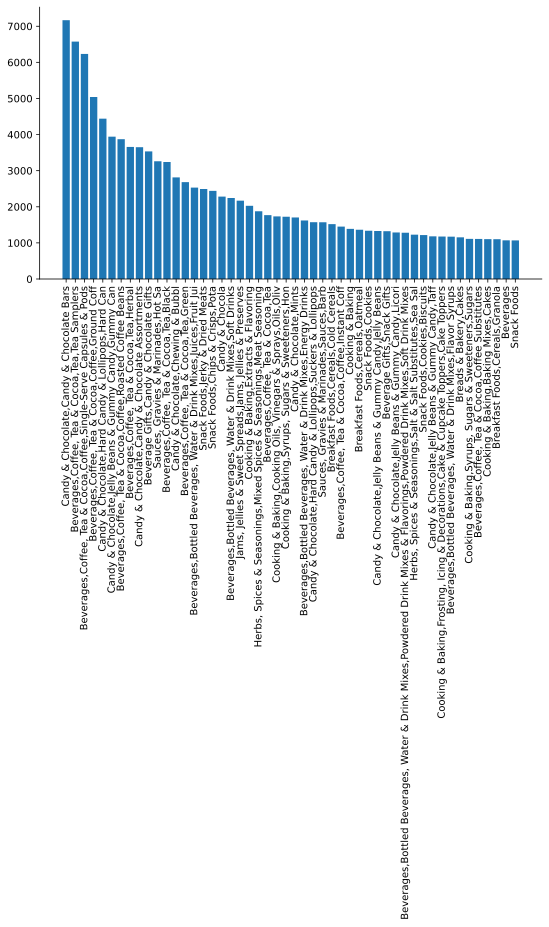

In [28]:
# Count occurences of each
category_counts = Counter(products['category']).most_common()
# Look at the distribution
plt.figure(figsize=(9, 5))
plt.bar([x[0] for x in category_counts[0:50]],
        [x[1] for x in category_counts[0:50]],
        width=0.8)
plt.xticks(rotation=90)
plt.title('')
sns.despine()

In [29]:
# Merge reviews and products datasets
product_reviews = pd.merge(left=reviews_compiled, right=products, left_on='asin', right_on='asin')

In [ ]:
# Save for tableau
product_reviews.to_csv(r'/Users/jbpatty/project-4/project_reviews.csv', index = False)

### Word Cloud

In [11]:
review_words = ''
stop_words = ''

# Iterating through the data file 
for i in reviews_compiled.review_text: 
    i = str(i) 
    separate = i.split() 
    for j in range(len(separate)): 
        separate[j] = separate[j].lower() 
      
    review_words += " ".join(separate)+" "

In [12]:
# Creating the Word Cloud
final_wordcloud = WordCloud(width = 800, height = 800, 
                background_color ='black', 
                stopwords = stop_words, 
                min_font_size = 10).generate(review_words)

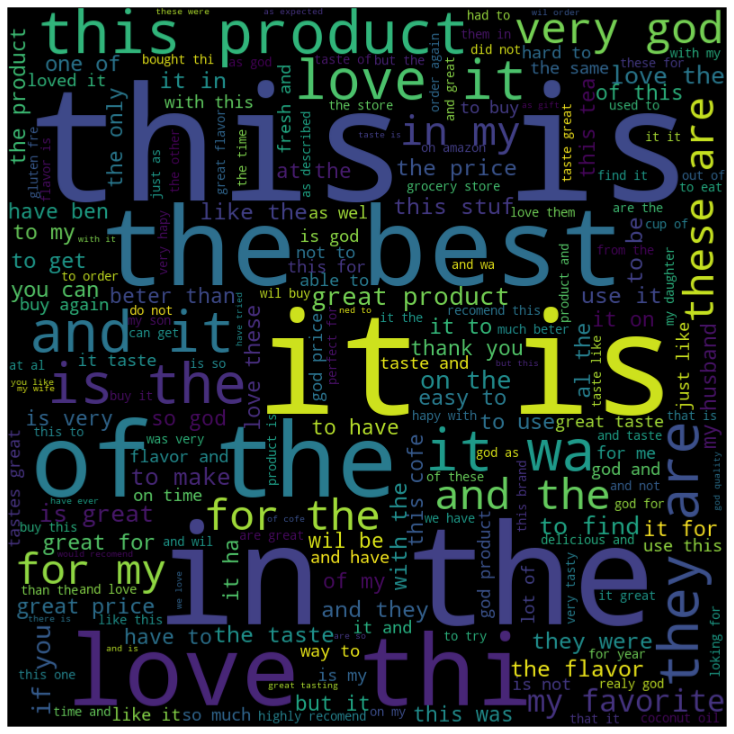

In [13]:
# Displaying the WordCloud                    
plt.figure(figsize = (10, 10), facecolor = None) 
plt.imshow(final_wordcloud) 
plt.axis("off") 
plt.tight_layout(pad = 0) 
  
plt.show()

### Scattertext

In [ ]:
reviews_df.drop(columns=['spacy_doc'])

In [ ]:
corpus = st.CorpusFromPandas(reviews_df,
                             category_col='review',
                             text_col='sentiment',
                             nlp=nlp).build()

In [ ]:
# Save to access later
reviews_df.to_pickle('/Users/jbpatty/project-4/corpus.to_pickle')

In [ ]:
# Pull in data
data = pd.read_pickle(r'/Users/jbpatty/project-4/amazon_data_cleaned.to_pickle')

In [ ]:
html = st.produce_scattertext_explorer(
    corpus,
    category='review', 
    category_name='positive', 
    not_category_name='negative',
    minimum_term_frequency=0, 
    pmi_threshold_coefficient=0,
    width_in_pixels=1000, 
    metadata=reviews,
    transform=st.Scalers.dense_rank)

In [ ]:
open('./demo_compact.html', 'w').write(html)